In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

So this is a quick run through of all things Volterra and Generating series.

I've ran the generating series and serialised the outputs, it takes a fair while to run, around 35mins for $y_1 + y_2 + y_3 + y_4 + y_5$ with quadratic and cubic nonlinearities in symbolic form. I've currently got $y_6$ running but it's been going since ~7pm yesterday. The bottleneck in the code is the partial fractions decomposition, and I don't think there's much I can do about that?

All of the values used are the same as the ones in the paper "Analysis of Nonlinear System Response to an Impulse Excitation".

I'll load some of the serialised results in here so you can see what's going on :)

# Comparison of Generating Series and Contour Integration

In [2]:
import numpy as np
import pickle as pkl
import dill
import matplotlib.pyplot as plt

# VCI is my shorthand for Volterra contour integration (aka the results from the paper).
from vci_quad_cube import y1 as y1_vci
from vci_quad_cube import y2 as y2_vci
from vci_quad_cube import y3 as y3_vci

# Runge-Kutta stuff.
from rk_quad_cube import duffing_equation
from scipy.integrate import solve_ivp

# Some parameters that are imported into all the files relating to this.
from params import plot
from params import iter_depth                            # Generating series param
from params import m, c, k1, k2, k3, init_cond, A_range  # Duffing params
from params import t_span, dt, t                         # Runge-kutta params

# iter_depth = 5 (number of Volterra terms to calculate)

# m = 1
# c = 20
# k1 = 1e4
# k2 = 1e7
# k3 = 5e9

# init_cond = (0, 0), Zero initial conditions.
# A_range = 0 to 0.15 in 0.01 steps.
# t_span = (0, 0.2) 
# dt = 1e-4.
# t = 0 to 0.2 in steps of dt.

Creating a matrix for the Runge-Kutta solutions, time along rows, and amplitude along columns. I'll only use the seventh index ($0.07N$) in this first section, but I'll use them all in the error analysis in the second section.

In [3]:
y_rks = []
for A in A_range:
    sol = solve_ivp(
        duffing_equation, t_span, init_cond, method='RK45', t_eval=t,
        args=(m, c, k1, k2, k3, A)
    )
    y_rks.append(sol.y[0])

y_rks = np.vstack(y_rks).T

Load in the stored functions determined using the generating series method. These functions take two parameters, amplitude and time.

In [4]:
volterra_gen = []
for i in range(1, iter_depth+2):
    with open(f"quad_cube_y{i}_lambdify_A_t_gen.txt", "rb") as f_read:
        volterra_gen.append(dill.load(f_read))

I take the real part of the numpy array below, as previous numpy arrays in the calculation were complex. The values at this stage are completely real, just the array data type was preserved.

In [5]:
A = 0.07 # Fig. 8 in the paper.

y1_gen = volterra_gen[0](A, t).real
y2_gen = volterra_gen[1](A, t).real
y3_gen = volterra_gen[2](A, t).real

I'm going to overlay the Volterra terms deduced using countour integration and the generating series in the figure below. We <i>should</i> expect them to be the same.

Text(0.5, 1.0, "Comparison of Duffing's equation solutions with an impulse amplitude=0.07")

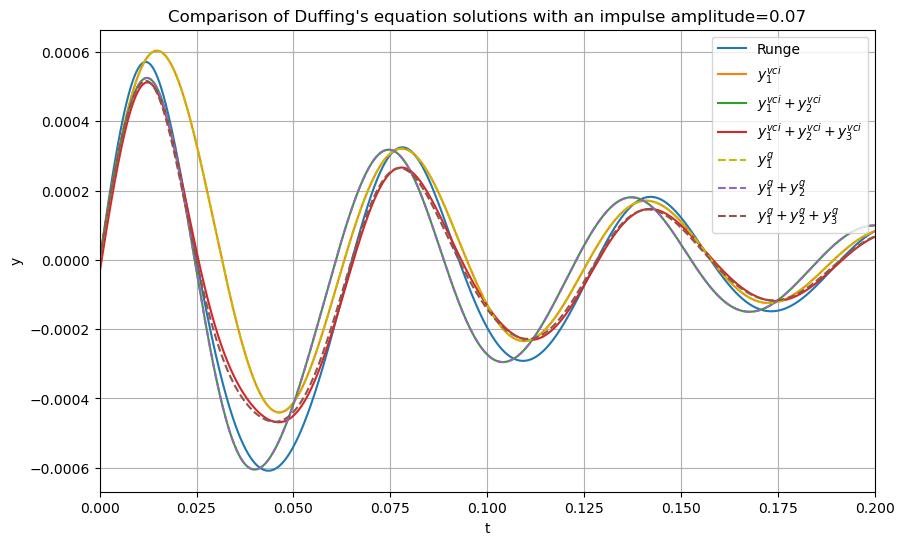

In [6]:
figax = plot(y_rks[:, 7], None, "Runge")

figax = plot(y1_vci, figax, "$y_1^{vci}$")
figax = plot(y1_vci + y2_vci, figax, "$y_1^{vci} + y_2^{vci}$")
figax = plot(y1_vci + y2_vci + y3_vci, figax, "$y_1^{vci} + y_2^{vci} + y_3^{vci}$")

figax = plot(y1_gen, figax, "$y_1^g$", c="y", linestyle="--")
figax = plot(y1_gen + y2_gen, figax, "$y_1^g + y_2^g$", linestyle="--")
figax = plot(
    y1_gen + y2_gen + y3_gen, figax, "$y_1^g + y_2^g + y_3^g$", linestyle="--"
)
fig, ax = figax
ax.set_title(
    f"Comparison of Duffing's equation solutions with an impulse amplitude={A}"
)

You can see here that $y_1^v$ is the same as $y_1^g$ and $y_1^v + y_2^v$  is the same as $y_1^g + y_2^g$ (I've equated these numerically and they're exact). However there seems to be a disagreement in the third term. I'll plot these terms by themselves below.

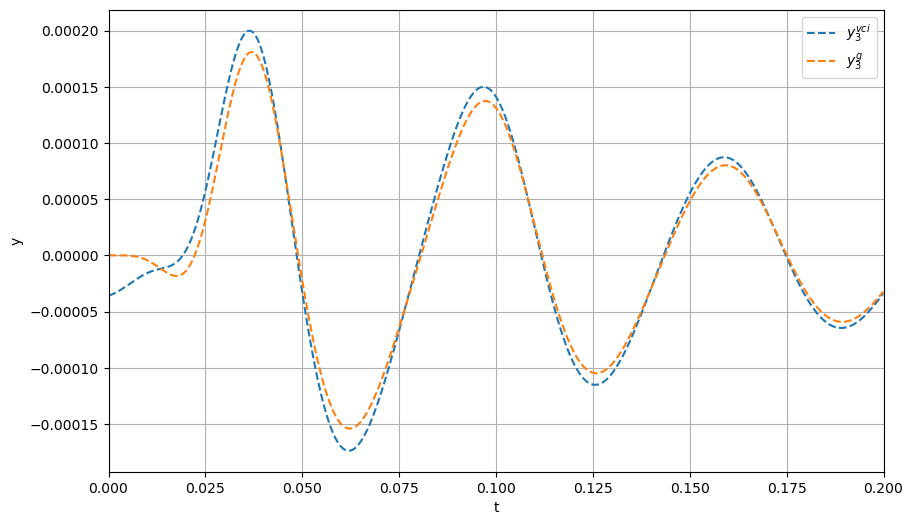

In [7]:
figax = plot(
    y3_vci, None, "$y_3^{vci}$", linestyle="--"
)
figax = plot(
    y3_gen, figax, "$y_3^g$", linestyle="--"
)

They're obviously different. I think there is an error with $y_3^{vci}$. It appears to be defying the zero initial conditions constraint.

There are two reasons that I can think for the contour integration and generating series expansions not being equivalent:
<ol>
    <li>
        <b>Copying Error:</b> I used mathpix to convert the equation in the paper to LaTex and then I converted it to Python from LateX. I've also checked over my copied version for $y_3$ from the paper three times (once with Chris) and we're         somewhat sure the version I've got in Python matches the one in the paper (I'm not ruling out the possibility of me being a massive idiot though). What I have typed up for $y_3^{vci}$ doesn't align with the pictures in the paper, but my $y_3^g$ does match. So I'm leaning towards there being a typo in $y_3^{k_2}$ in the paper (the contour integration and generating series $y_3^{k_3}$ are equivalent). If either of you have the derivation/ code used I'd be interested to see this.
    </li>
    <li>
        <b>There is something wrong in my code</b> Hopefully not this, as I wouldn't know where to start!
    </li>
    
</ol>


Anyway, here are the next two terms that I've computed.

C:\Users\trist\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


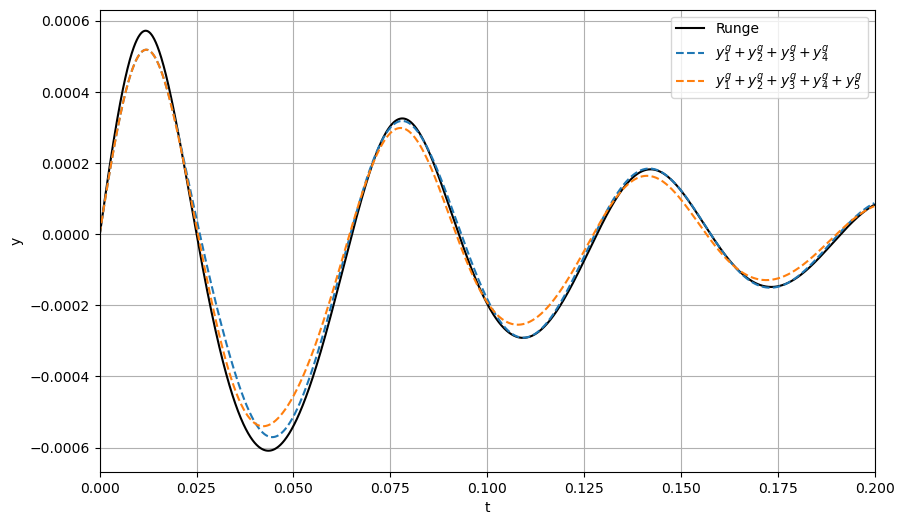

In [8]:
y4_gen = volterra_gen[3](A, t)
y5_gen = volterra_gen[4](A, t)

figax = plot(y_rks[:, 7], None, "Runge", c="k")
figax = plot(
    y1_gen + y2_gen + y3_gen + y4_gen, figax, "$y_1^g + y_2^g + y_3^g + y_4^g$", linestyle="--"
)
figax = plot(
    y1_gen + y2_gen + y3_gen + y4_gen + y5_gen, figax, "$y_1^g + y_2^g + y_3^g + y_4^g + y_5^g$", linestyle="--"
)

Interestingly, the fourth order expansion looks to be a better fit than the fifth order? I assume $y_5^g$ is diveregent at this impulse amplitude?

And here are all the terms by themselves.

Text(0.5, 1.0, 'Individual Volterra terms with an impulse amplitude=0.07')

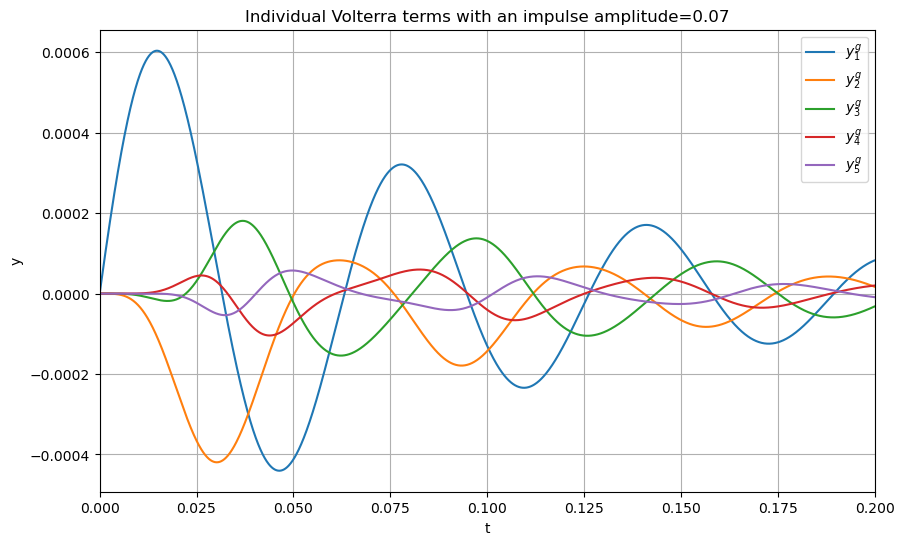

In [9]:
figax = plot(y1_gen, None, "$y_1^g$")
figax = plot(y2_gen, figax, "$y_2^g$")
figax = plot(y3_gen, figax, "$y_3^g$")
figax = plot(y4_gen, figax, "$y_4^g$")
figax = plot(y5_gen, figax, "$y_5^g$")
fig, ax = figax
ax.set_title(
    f"Individual Volterra terms with an impulse amplitude={A}"
)

Also, I'm going to display the symbolic representations of the terms that I've calculated as they're in a different from to the ones in the paper. The generating series ones are all in terms of exponentials.

In [14]:
iter_depth=4

symbolic_gen = []
for i in range(1, iter_depth+2):
    with open(f"quad_cube_y{i}_volt_sym.txt", "rb") as f_read:
        symbolic_gen.append(pkl.load(f_read))   

In the terms below, $a_1$ and $a_2$ are the roots to the quadratic $mx^2 + cx + k_1x = 0$.

In [15]:
symbolic_gen[0]

(A*exp(-a2*t)/(a1 - a2), -A*exp(-a1*t)/(a1 - a2))

One thing I've not tested yet is for symmetry in $a_1$ and $a_2$. The linear term looks symmetric in $a_1$ and $a_2$ to me. This feels like something that should be explicitly addressed, the generating series papers don't mention anything. I wouldn't know how to go about this for the higher order terms, other than a crude numerical example like this:

In [16]:
from sympy import symbols
_a1, _a2 = symbols("a1 a2")
symbolic_gen[0].subs({_a1: 1, _a2: 10})

AttributeError: 'tuple' object has no attribute 'subs'

In [ ]:
symbolic_gen[0].subs({_a1: 10, _a2: 1})

And the remaining terms:

In [19]:
sum(symbolic_gen[1])

A**2*k2*exp(-2*a2*t)/(a1**3*a2 - 4*a1**2*a2**2 + 5*a1*a2**3 - 2*a2**4) + A**2*k2*exp(-2*a1*t)/(-2*a1**4 + 5*a1**3*a2 - 4*a1**2*a2**2 + a1*a2**3) - 2*A**2*k2*exp(-a2*t)/(2*a1**3*a2 - 3*a1**2*a2**2 + a1*a2**3) + 2*A**2*k2*exp(t*(-a1 - a2))/(a1**3*a2 - 2*a1**2*a2**2 + a1*a2**3) - 2*A**2*k2*exp(-a1*t)/(a1**3*a2 - 3*a1**2*a2**2 + 2*a1*a2**3)

In [20]:
sum(symbolic_gen[2])

-A**3*k2**2*exp(-3*a2*t)/(2*a1**6*a2 - 19*a1**5*a2**2 + 72*a1**4*a2**3 - 140*a1**3*a2**4 + 148*a1**2*a2**5 - 81*a1*a2**6 + 18*a2**7) - A**3*k2**2*exp(-3*a2*t)/(2*a1**6*a2 - 21*a1**5*a2**2 + 89*a1**4*a2**3 - 195*a1**3*a2**4 + 233*a1**2*a2**5 - 144*a1*a2**6 + 36*a2**7) - 4*A**3*k2**2*exp(-2*a1*t)/(-4*a1**6*a2 + 24*a1**5*a2**2 - 55*a1**4*a2**3 + 60*a1**3*a2**4 - 31*a1**2*a2**5 + 6*a1*a2**6) + 3*A**3*k2**2*exp(t*(-a1 - 2*a2))/(a1**5*a2**2 - 4*a1**4*a2**3 + 4*a1**3*a2**4 + 2*a1**2*a2**5 - 5*a1*a2**6 + 2*a2**7) + A**3*k2**2*exp(-3*a2*t)/(a1**5*a2**2 - 9*a1**4*a2**3 + 31*a1**3*a2**4 - 51*a1**2*a2**5 + 40*a1*a2**6 - 12*a2**7) + A**3*k2**2*exp(-3*a1*t)/(-6*a1**7 + 23*a1**6*a2 - 34*a1**5*a2**2 + 24*a1**4*a2**3 - 8*a1**3*a2**4 + a1**2*a2**5) - 12*A**3*k2**2*exp(-2*a1*t)/(4*a1**6*a2 - 20*a1**5*a2**2 + 35*a1**4*a2**3 - 25*a1**3*a2**4 + 6*a1**2*a2**5) - 3*A**3*k2**2*exp(-a2*t)/(-6*a1**6*a2 + 5*a1**5*a2**2 + 5*a1**4*a2**3 - 5*a1**3*a2**4 + a1**2*a2**5) - 4*A**3*k2**2*exp(-2*a2*t)/(2*a1**5*a2**2 - 9*a

In [ ]:
# These are a bit long, so I've commented them out.
# symbolic_gen[3] # I displayed this out of interest as it's the first mixing term of k2 and k3 but it's quite meaty.
# symbolic_gen[4] # I've not even bothered displaying this.

With some mathematical jiggery-pokery I'd assume you'd be able to manipulate the contour integration and generating series forms into one another.

# Error analysis with Runge-Kutta

From here on out, I will only consider the terms from the generating series method.

In [ ]:
def rrse(pred, true):
    """
    Relative root squared error along each column.
    """
    numer = np.square(np.subtract(        pred, true)).sum(0)
    denom = np.square(np.subtract(true.mean(0), true)).sum(0)
    
    return 100 * np.sqrt(np.divide(numer, denom))
        
# Creating array of values, time along rows, amplitude along columns.
all_funcs = []
for func in volterra_gen:
    all_amps = []
    for amp in A_range:
        all_amps.append(func(amp, t).real)
    all_funcs.append(np.vstack(all_amps).T)
    
ys_summed = []
rrses = []
for i, times in enumerate(all_funcs):
    if i == 0:
        ys_summed.append(times)
    else:
        ys_summed.append(ys_summed[-1] + times)
        # assert (ys_summed[-1] == (ys_summed[-2] + times)).all()
    rrses.append(rrse(y_rks, ys_summed[-1]))

Divide by zero warning because I've included $A=0$ and $t=0$.

In [ ]:
fig_error = plt.figure()
ax_error = fig_error.gca()
for i, root_rel_err in enumerate(rrses, 1):
    ax_error.plot(A_range, root_rel_err, label=f"up to $y^g_{i}$")
ax_error.legend()
ax_error.set_title(
    "Relative Root Squared Error with Runge Kutta"
)

This seems to be a fair bit different to the plot in the paper, I'd I'm not entirely sure why?

And then finally, I thought I'd list the responses at all the amplitudes.

In [ ]:
for amp_index in range(len(A_range)):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].plot(t, y_rks[:, amp_index], label="$y_{rk}$", c="k")
    axs[1].plot(t, y_rks[:, amp_index], label="$y_{rk}$", c="k")

    for i, (y_s, y_i) in enumerate(zip(ys_summed, all_funcs), 1):
        axs[0].plot(
            t, y_s[:, amp_index], label=f"up to $y_{i}^g$", linestyle="--",
            alpha=0.7
        )
        axs[1].plot(
            t, y_i[:, amp_index], label=f"$y_{i}^g$", linestyle="--", alpha=0.7
        )
    axs[0].legend(loc=1, prop={"size": 10})
    axs[1].legend(loc=1, prop={"size": 10})
    axs[0].grid(True)
    axs[1].grid(True)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('y')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('y')
    axs[0].set_title(
        f"Volterra series at impulse ampliude {A_range[amp_index]:.2f}"
    )
    axs[1].set_title(
        f"Individual Volterra terms at impulse amplitude {A_range[amp_index]:.2f}"
    )



In [ ]:
# Need this here to render in figure above